# Figure 6 and SI Figure S3: dynamic component and ascent fraction change

Anna Mackie, 2022

Plots the longwave, shortwave and net dynamic components of the cloud feedback against the fractional change in ascent fraction

In [1]:
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib as mpl
mpl.rcParams['font.size'] = 16

from scipy import stats
from scipy.interpolate import UnivariateSpline
import matplotlib as mpl
mpl.rcParams['font.size'] = 16
import sys
sys.path.append('../')
import funcs


models = ['CM1', 'dam',  'ICON_LEM_CRM', 'ICON_NWP_CRM', 'MESONH',  'SAM_CRM', 'SCALE', 'UCLA-CRM',
          'UKMOi-vn11.0-CASIM', 'UKMOi-vn11.0-RA1-T', 'UKMOi-vn11.0-RA1-T-nocloud', 'WRF_COL_CRM']
m = len(models)
cols =  np.load('color_grid.npy', allow_pickle = True)

# limits of vertical velocity, common across models
pl = 0.22 # pos limit
nlim= -0.07 # neg limit
bs = 0.001 # bin size

bins = np.arange(nlim, pl, bs) #creates bins
b = len(bins)
print('no of vertical velocity bins: ', b)
mnbin = [] # create array of the mid-point between bin limits for plotting
for i in range(1,b):
    mnbin = np.append(mnbin, np.mean([bins[i-1], bins[i]])*100)

lets = ['a)', 'b)', 'c)', 'd)', 'e)', 'f)', 'g)', 'h)', 'j)']    
deltaT = 5
pLev = 500
arrs = ['lwcrf', 'swcrf']
temps = ['295', '300', '305']
ms = 8

no of vertical velocity bins:  291


CM1


/home/users/arm33/RCEMIP/allMod/../funcs.py:120: RuntimeWarning: Mean of empty slice
  arrbin = [np.nanmean(arr[dig==i]) for i in range(1,b)]


dam
ICON_LEM_CRM
ICON_NWP_CRM
MESONH
SAM_CRM
SCALE
UCLA-CRM
UKMOi-vn11.0-CASIM
UKMOi-vn11.0-RA1-T
UKMOi-vn11.0-RA1-T-nocloud
WRF_COL_CRM
slope is:  0.06199893185578157  and standard error is: 0.008897908698270307
slope is:  -0.07698971079296665  and standard error is: 0.010019428345619247
slope is:  -0.014990778937185078  and standard error is: 0.006973115680372262


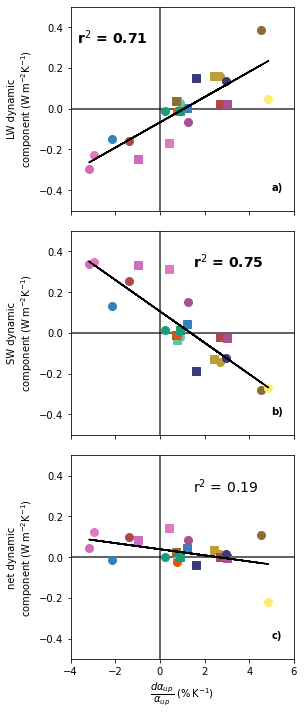

In [2]:
fig1, axes1 = plt.subplots(3,1)

fxlim= [-4, 6]#[-7, 15]
ylim = [-0.5, 0.5]
tits = ['LW', 'SW', 'net']

no_anoms = 2 # number of outliers: MESONH and UCLA at 305-300K
dyns, fups, Is, Iorgs = np.empty((3,2*m-no_anoms)),np.empty((2*m-no_anoms)),np.empty((2*m-no_anoms)),np.empty((2*m-no_anoms))

c = 0
for k in range(m):
    model = models[k]
    print(model)
    dp = '/home/users/arm33/RCEMIP/'+ model +'/processed_new/2D/large'    
    dp3 = '/home/users/arm33/RCEMIP/'+ model +'/processed_new/3D/large'
    
    # calculate ascent fraction
    
    for j in [0,1]: # loop over two temp changes
        if j==0:
            con,new = '295', '300'
            marker = 'o'

            #295
            wa = np.load(dp3 + con + 'wa_profile_25d.npy', allow_pickle = True)
            pa = np.load(dp3 + con + 'pa_profile_25d.npy', allow_pickle = True)/100
            wa500_alltemp = np.empty((3,np.shape(wa)[0],np.shape(wa)[2], np.shape(wa)[3]))
            wa500_alltemp[0,] = funcs.getPlevel(wa, pa, pLev)
            #300
            wa = np.load(dp3 + new + 'wa_profile_25d.npy', allow_pickle = True)
            pa = np.load(dp3 + new + 'pa_profile_25d.npy', allow_pickle = True)/100
            wa500_alltemp[1,] = funcs.getPlevel(wa, pa, pLev)


        if j==1:
            con,new = '300', '305'
            marker = 's'
            #305
            wa = np.load(dp3 + new + 'wa_profile_25d.npy', allow_pickle = True)
            pa = np.load(dp3 + new + 'pa_profile_25d.npy', allow_pickle = True)/100
            wa500_alltemp[2,] = funcs.getPlevel(wa, pa, pLev)
            
       
        # lower temperature ascent fraction
        Cw500 = wa500_alltemp[j]
        Cfup = funcs.calcFup(Cw500)
        
        # and at higher
        Nw500 = wa500_alltemp[j+1]
        Nfup = funcs.calcFup(Nw500)
        
        #calculate fracitonal change in ascent fraction
        df = funcs.fracChange(Nfup, Cfup, deltaT)            
        
        if model =='MESONH' and j==1: # skip outlier
            break
        elif model =='UCLA-CRM' and j==1: # skip outlier
            break
        else:
            fups[c] = df # add to array

        # now calculate dynamic component
        for i in range(3): # loop over LW/SW/net
            if i==0 or i==1:
                arr = arrs[i]
                #calc dynamic effect with 3D data
                crf1 = np.load(dp + con + arr +'24hrs.npy', allow_pickle = True)
                crf2 = np.load(dp + new + arr +'24hrs.npy', allow_pickle = True)
            elif i==2:
                crf1 = np.load(dp +  con + 'lwcrf24hrs.npy', allow_pickle = True) + np.load(dp + con + 'swcrf24hrs.npy', allow_pickle = True)
                crf2 = np.load(dp +  new + 'lwcrf24hrs.npy', allow_pickle = True) + np.load(dp + new + 'swcrf24hrs.npy', allow_pickle = True)
        
            # lower temperature functions
            dig1 = np.digitize(Cw500, bins)
            A1 = funcs.createA(dig1, b)
            R1 = funcs.createR(crf1, dig1, b)
            R1 = funcs.rpTrailingZeros(A1,R1)
            # higher temperature functions
            dig2 = np.digitize(Nw500, bins)
            A2 = funcs.createA(dig2, b)
            R2 = funcs.createR(crf2, dig2, b)
            R2 = funcs.rpTrailingZeros(A2,R2)

            dR = R2 - R1
            dA = A2 - A1

            tot, th, dyn, nl = funcs.decompose(A1, A2, R1, R2, deltaT)

            # plot change in ascent fraction agianst dynamic component
            ax = axes1[i]
            if k==0 and j==0:
                ax.plot([0,0],ylim, 'k-', alpha = 0.8)
                ax.plot(fxlim, [0,0], 'k-', alpha= 0.8)
            ax.plot(df,dyn,  color = cols[k], marker= marker, markersize = ms)
            
            if i==2:
                ax.set_xlabel('$\dfrac{d\\alpha_{up}}{\\alpha_{up}}$ (%$\,$K$^{-1}$) ')
            else:
                ax.set_xticklabels('')
            ax.set_ylim(ylim)
            ax.set_xlim(fxlim)

            
            
            if model == 'MESONH' and j==1:
                print('removing MESONH')
            elif model == 'UCLA-CRM' and j==1:
                print('removing UCLA')
                
            else:
                dyns[i,c] = dyn     # add to array for statistic calculation       
                
        c+=1
        
# add in correlation coefficient    
d=0
for i in range(3):
    if i==0:
        r2 = funcs.addr2line(fups,dyns[i,:],axes1[i], position = [0.03, 0.85], fontsize= 14 )
    else:
        r2 = funcs.addr2line(fups,dyns[i,:],axes1[i], position = [0.55, 0.85], fontsize = 14)
    
    axes1[i].text(0.9, 0.1, lets[d], fontweight = 'bold',transform=axes1[i].transAxes)
    d+=1

axes1[0].set_ylabel('LW dynamic\ncomponent (W$\,$m$^{-2}$K$^{-1}$)')        
axes1[1].set_ylabel('SW dynamic\ncomponent (W$\,$m$^{-2}$K$^{-1}$)')     
axes1[2].set_ylabel('net dynamic\ncomponent (W$\,$m$^{-2}$K$^{-1}$)')        
        
fig1.set_size_inches(4,12) 
fig1.subplots_adjust(hspace = 0.1, wspace = 0.2)
fig1.savefig('paperplots/Fig6.pdf', bbox_inches = 'tight')


## Figure S3 - Repeat with MESONH and UCLA at 305-300K left in

Done in response to a reviewer question

CM1


/home/users/arm33/RCEMIP/allMod/../funcs.py:120: RuntimeWarning: Mean of empty slice
  arrbin = [np.nanmean(arr[dig==i]) for i in range(1,b)]


dam
ICON_LEM_CRM
ICON_NWP_CRM
MESONH
SAM_CRM
SCALE
UCLA-CRM
UKMOi-vn11.0-CASIM
UKMOi-vn11.0-RA1-T
UKMOi-vn11.0-RA1-T-nocloud
WRF_COL_CRM
slope is:  0.09032302184754686  and standard error is: 0.017647399881036554
slope is:  -0.12636904295168552  and standard error is: 0.026722733885251034
slope is:  -0.036046021104138695  and standard error is: 0.011434133129351718


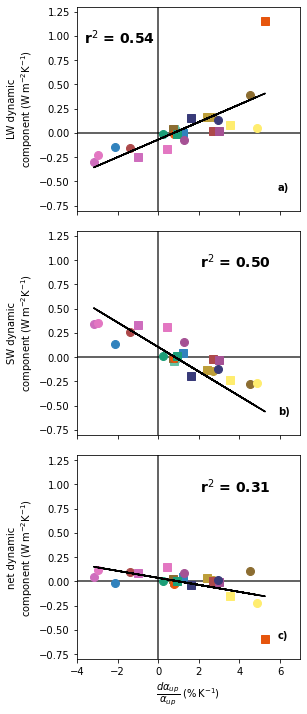

In [3]:
fig1, axes1 = plt.subplots(3,1)

fxlim= [-4, 7]#[-7, 15]
ylim = [-0.8, 1.3]
tits = ['LW', 'SW', 'net']

no_anoms = 0 # leave in MESONH and UCLA at 305-300K
dyns, fups, Is, Iorgs = np.empty((3,2*m-no_anoms)),np.empty((2*m-no_anoms)),np.empty((2*m-no_anoms)),np.empty((2*m-no_anoms))

c = 0
for k in range(m):
    model = models[k]
    print(model)
    dp = '/home/users/arm33/RCEMIP/'+ model +'/processed_new/2D/large'    
    dp3 = '/home/users/arm33/RCEMIP/'+ model +'/processed_new/3D/large'
    
    # calculate ascent fraction
    
    for j in [0,1]: # loop over two temp changes
        if j==0:
            con,new = '295', '300'
            marker = 'o'

            #295
            wa = np.load(dp3 + con + 'wa_profile_25d.npy', allow_pickle = True)
            pa = np.load(dp3 + con + 'pa_profile_25d.npy', allow_pickle = True)/100
            wa500_alltemp = np.empty((3,np.shape(wa)[0],np.shape(wa)[2], np.shape(wa)[3]))
            wa500_alltemp[0,] = funcs.getPlevel(wa, pa, pLev)
            #300
            wa = np.load(dp3 + new + 'wa_profile_25d.npy', allow_pickle = True)
            pa = np.load(dp3 + new + 'pa_profile_25d.npy', allow_pickle = True)/100
            wa500_alltemp[1,] = funcs.getPlevel(wa, pa, pLev)


        if j==1:
            con,new = '300', '305'
            marker = 's'
            #305
            wa = np.load(dp3 + new + 'wa_profile_25d.npy', allow_pickle = True)
            pa = np.load(dp3 + new + 'pa_profile_25d.npy', allow_pickle = True)/100
            wa500_alltemp[2,] = funcs.getPlevel(wa, pa, pLev)
            
       
        # lower temperature ascent fraction
        Cw500 = wa500_alltemp[j]
        Cfup = funcs.calcFup(Cw500)
        
        # and at higher
        Nw500 = wa500_alltemp[j+1]
        Nfup = funcs.calcFup(Nw500)
        
        #calculate fracitonal change in ascent fraction
        df = funcs.fracChange(Nfup, Cfup, deltaT)            

        fups[c] = df  # add to array

        # now calculate dynamic component
        for i in range(3): # loop over LW/SW/net
            if i==0 or i==1:
                arr = arrs[i]
                #calc dynamic effect with 3D data
                crf1 = np.load(dp + con + arr +'24hrs.npy', allow_pickle = True)
                crf2 = np.load(dp + new + arr +'24hrs.npy', allow_pickle = True)
            elif i==2:
                crf1 = np.load(dp +  con + 'lwcrf24hrs.npy', allow_pickle = True) + np.load(dp + con + 'swcrf24hrs.npy', allow_pickle = True)
                crf2 = np.load(dp +  new + 'lwcrf24hrs.npy', allow_pickle = True) + np.load(dp + new + 'swcrf24hrs.npy', allow_pickle = True)
        
            # lower temperature functions
            dig1 = np.digitize(Cw500, bins)
            A1 = funcs.createA(dig1, b)
            R1 = funcs.createR(crf1, dig1, b)
            R1 = funcs.rpTrailingZeros(A1,R1)
            # higher temperature functions
            dig2 = np.digitize(Nw500, bins)
            A2 = funcs.createA(dig2, b)
            R2 = funcs.createR(crf2, dig2, b)
            R2 = funcs.rpTrailingZeros(A2,R2)

            dR = R2 - R1
            dA = A2 - A1

            tot, th, dyn, nl = funcs.decompose(A1, A2, R1, R2, deltaT)

            # plot change in ascent fraction agianst dynamic component
            ax = axes1[i]
            if k==0 and j==0:
                ax.plot([0,0],ylim, 'k-', alpha = 0.8)
                ax.plot(fxlim, [0,0], 'k-', alpha= 0.8)
            ax.plot(df,dyn,  color = cols[k], marker= marker, markersize = ms)
            
            if i==2:
                ax.set_xlabel('$\dfrac{d\\alpha_{up}}{\\alpha_{up}}$ (%$\,$K$^{-1}$) ')
            else:
                ax.set_xticklabels('')
            ax.set_ylim(ylim)
            ax.set_xlim(fxlim)

            
            dyns[i,c] = dyn     # add to array for statistic calculation       
                
        c+=1
        
# add in correlation coefficient    
d=0
for i in range(3):
    if i==0:
        r2 = funcs.addr2line(fups,dyns[i,:],axes1[i], position = [0.03, 0.85], fontsize= 14 )
    else:
        r2 = funcs.addr2line(fups,dyns[i,:],axes1[i], position = [0.55, 0.85], fontsize = 14)
    
    axes1[i].text(0.9, 0.1, lets[d], fontweight = 'bold',transform=axes1[i].transAxes)
    d+=1

axes1[0].set_ylabel('LW dynamic\ncomponent (W$\,$m$^{-2}$K$^{-1}$)')        
axes1[1].set_ylabel('SW dynamic\ncomponent (W$\,$m$^{-2}$K$^{-1}$)')     
axes1[2].set_ylabel('net dynamic\ncomponent (W$\,$m$^{-2}$K$^{-1}$)')        
        
fig1.set_size_inches(4,12) 
fig1.subplots_adjust(hspace = 0.1, wspace = 0.2)
fig1.savefig('paperplots/SIFig3.pdf', bbox_inches = 'tight')
